
<h2 align="left"><i>Predicting Employee Churn with Decision Tree, Random Forests and Logical Regression Classifier</i></h2>

###### by Varun Kashyap

- Employee churn is the overall turnover in an organization's staff as existing employees leave and new ones are hired. The churn rate is usually calculated as the percentage of employees leaving the company over some specified time period. Although some staff turnover is inevitable, a high rate of churn is costly.

- Here, the aim is to analyze employee churn, find out why employees are leaving the company, and learn to predict churn and turnover trends.

### Importing Libraries
---

In [59]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [60]:
plt.rcParams['figure.figsize'] = (12,8)


### Exploratory Data Analysis
---

In [61]:
hr = pd.read_csv('data/employee_data.csv')
hr_orig = hr
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [62]:
hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Encoding Categorical Features
---

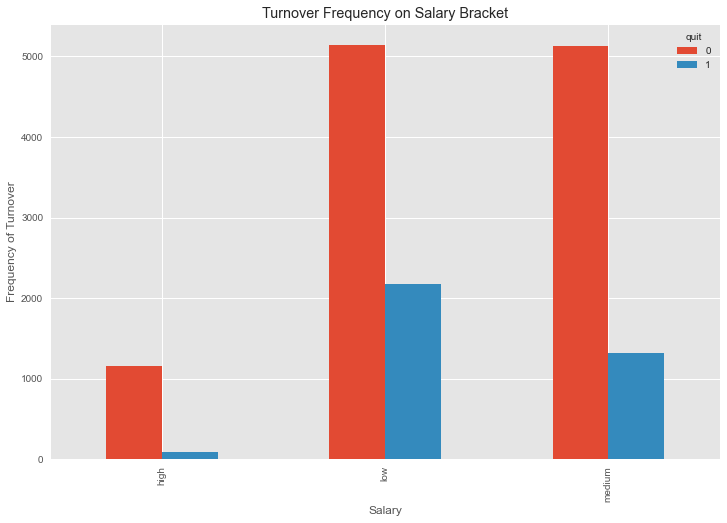

In [63]:
pd.crosstab(hr.salary,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

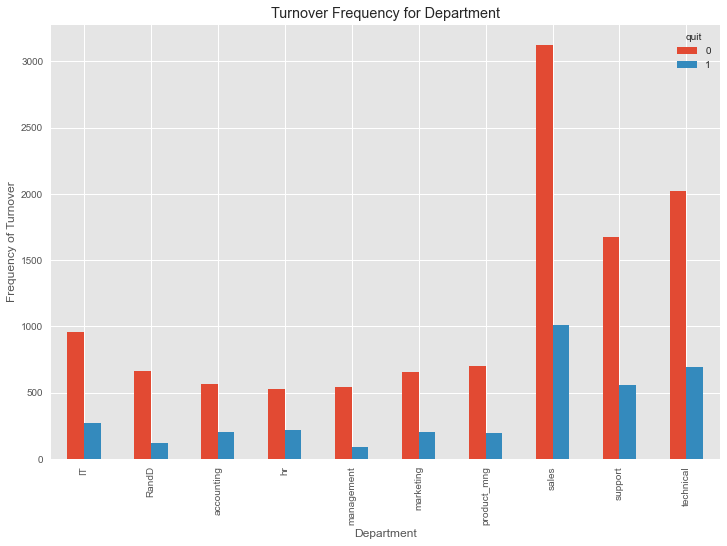

In [64]:
pd.crosstab(hr.department,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

In [65]:
cat_vars=['department','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr1=hr.join(cat_list)
    hr=hr1

In [66]:
hr.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'quit',
       'promotion_last_5years', 'department', 'salary', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype='object')

In [67]:
hr.drop(columns=['department','salary'], axis=1, inplace=True)
#hr.drop(hr.columns[[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

### Visualization of Class Imbalance
---

In [68]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

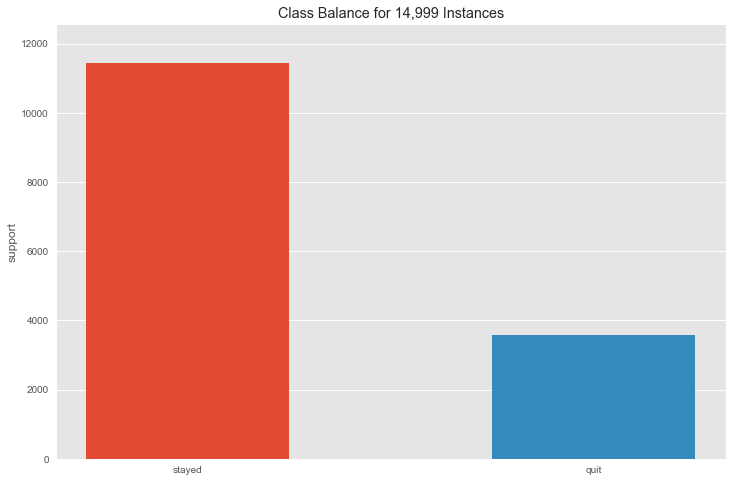

In [69]:
visualizer = ClassBalance(labels=["stayed", "quit"])

visualizer.fit(hr.quit)
visualizer.show();

### Creating Training and Test Sets
---

In [70]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    stratify=y)

### Building an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [72]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [73]:
@interact
def plot_tree(crit=["gini", "entropy"],
              split=["best", "random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter = split,
                                       max_depth = depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

    graph = Source(tree.export_graphviz(estimator,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator


interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Building an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [74]:
@interact
def plot_tree_rf(crit=["gini", "entropy"],
                 bootstrap=["True", "False"],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                      verbose=False).fit(X_train, y_train)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\nVisualizing Decision Tree:', 0)
    
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Feature Importance and Evaluation Metrics
---

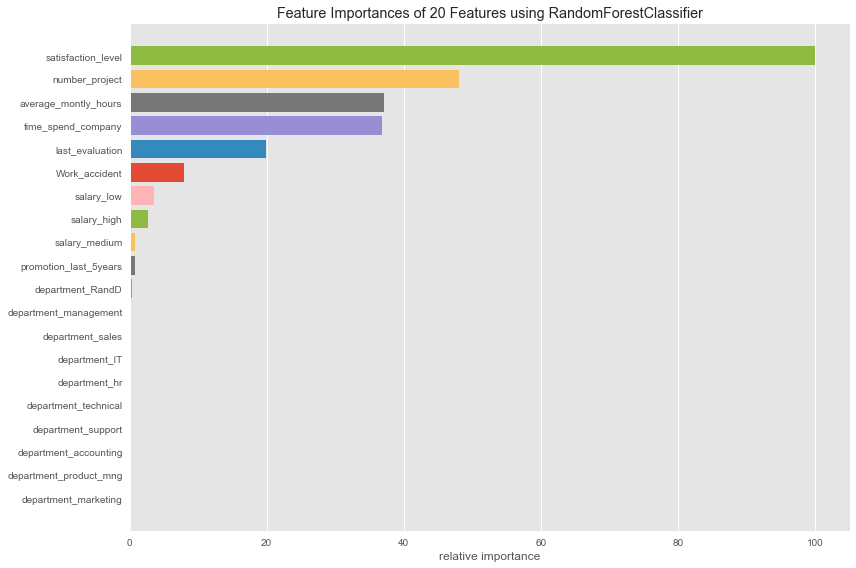

In [75]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();

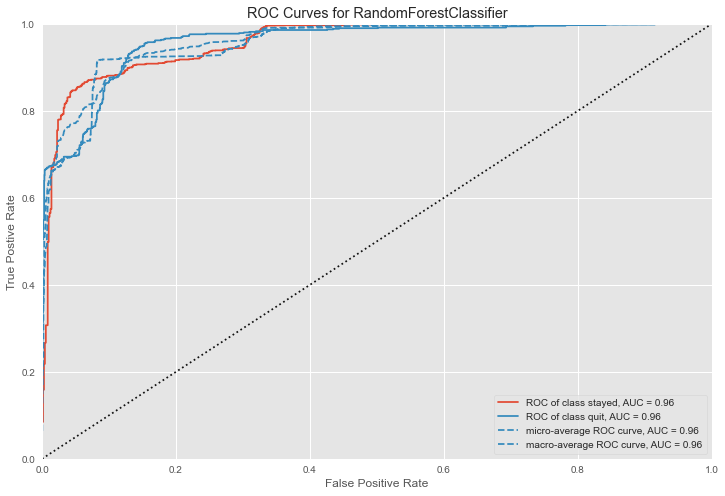

In [76]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

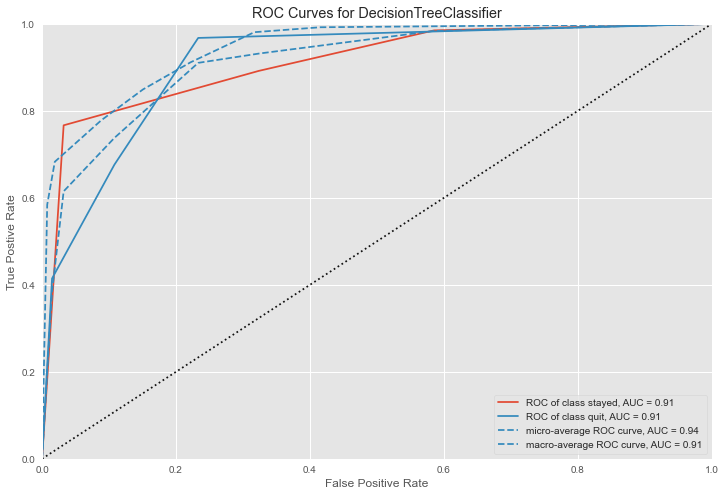

In [77]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

###  Comparison with Logistic Regression Classifier
---

Logistic Regression Accuracy: 0.789


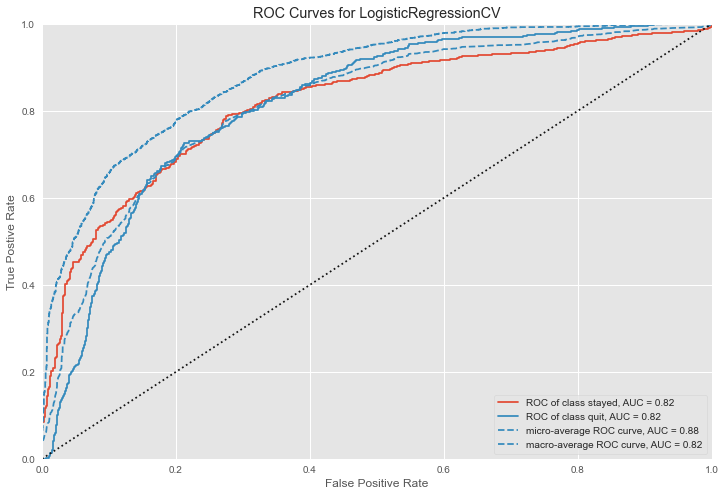

In [78]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(random_state=1, n_jobs=-1,max_iter=500,
                             cv=10)

lr = logit.fit(X_train, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lr.predict(X_test))))

visualizer = ROCAUC(lr, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

---
## _Alternate approach considering new Dataset_
---

In [79]:
#import modules
import pandas  # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
%matplotlib inline

In [80]:
data=pandas.read_csv('HR_comma_sep.csv')

In [81]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [82]:
data.tail()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low
14998,0.37,0.52,2,158,3,0,1,0,support,low


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
Departments              14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The Attributes can be described as -
- satisfaction_level: It is employee satisfaction point, which ranges from 0-1.
- last_evaluation: It is evaluated performance by the employer, which also ranges from 0-1.
- number_projects: How many numbers of projects assigned to an employee?
- average_monthly_hours: How many average numbers of hours worked by an employee in a month?
- time_spent_company: time_spent_company means employee experience. The number of years spent by an employee in the company.
- work_accident: Whether an employee has had a work accident or not.
- promotion_last_5years: Whether an employee has had a promotion in the last 5 years or not.
- Departments: Employee's working department/division.
- Salary: Salary level of the employee such as low, medium and high.
- left: Whether the employee has left the company or not.

### Data Insights
---

In the given dataset, we have two types of employee one who stayed and another who left the company. So, we can divide data into two groups and compare their characteristics. Here, we can find the average of both the groups using groupby() and mean() function.

In [84]:
left = data.groupby('left')
left.mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Here you can interpret, Employees who left the company had low satisfaction level, low promotion rate, low salary, and worked more compare to who stayed in the company.

In [85]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Data Visualization
---

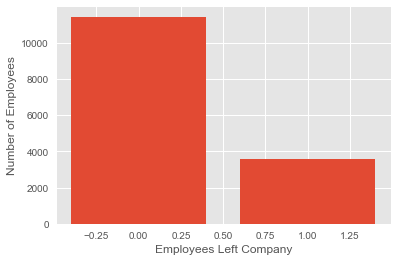

In [86]:
#Number of Employees left
left_count=data.groupby('left').count()
plt.bar(left_count.index.values, left_count['satisfaction_level'])
plt.xlabel('Employees Left Company')
plt.ylabel('Number of Employees')
plt.show()

In [87]:
data.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

Here, we can see out of 15,000 approx 3,571 were left, and 11,428 stayed. The no of employee left is 23 % of the total employment

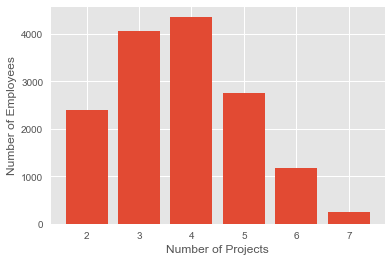

In [88]:
#Number of Projects
num_projects=data.groupby('number_project').count()
plt.bar(num_projects.index.values, num_projects['satisfaction_level'])
plt.xlabel('Number of Projects')
plt.ylabel('Number of Employees')
plt.show()

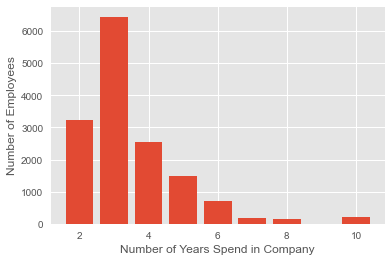

In [89]:
#Time spent in the Company
time_spent=data.groupby('time_spend_company').count()
plt.bar(time_spent.index.values, time_spent['satisfaction_level'])
plt.xlabel('Number of Years Spend in Company')
plt.ylabel('Number of Employees')
plt.show()

Most of the employee experience between 2-4 years. Also, there is a massive gap between 3 years and 4 years experienced employee.

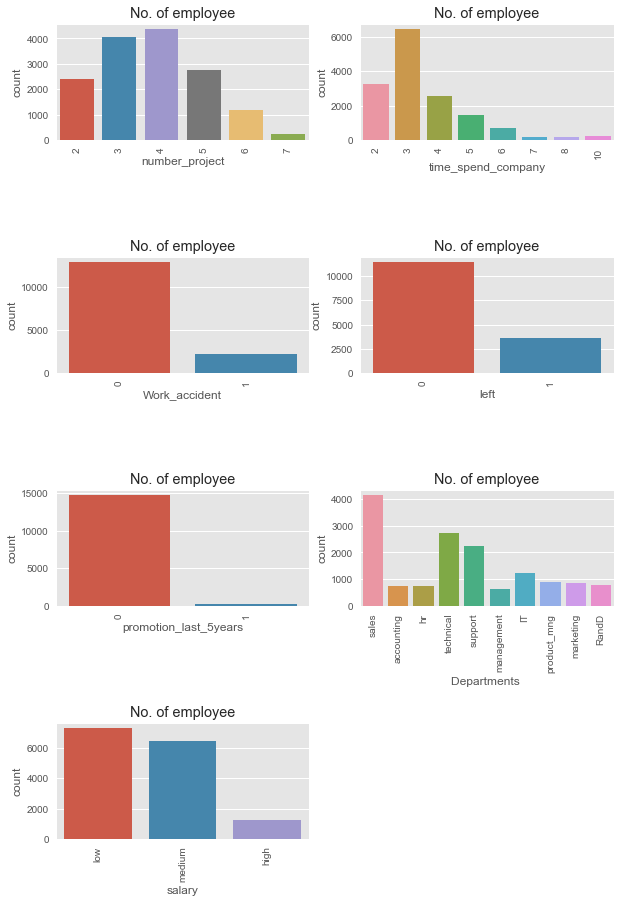

In [90]:
features=['number_project','time_spend_company','Work_accident','left', 'promotion_last_5years','Departments ','salary']
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = data)
    plt.xticks(rotation=90)
    plt.title("No. of employee")

We can observe the following points in the above visualization:

- Most of the employee is doing the project from 3-5.
- There is a huge drop between 3 years and 4 years experienced employee.
- The no of employee left is 23 % of the total employment.
- A decidedly less number of employee get the promotion in the last 5 year.
- Sales department has the maximum employees followed by technical & support
- Most of the employees are getting salary either medium or low.

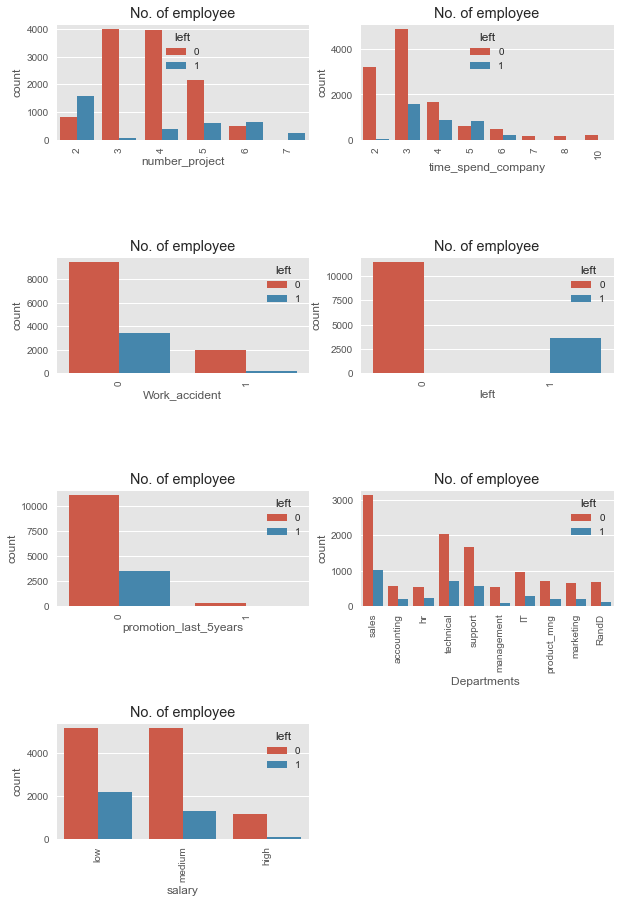

In [91]:
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = data, hue='left')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

- Those employees who have the number of projects more than 5 were left the company.
- The employee who had done 6 and 7 projects, left the company it seems to like that they were overloaded with work.
- The employee with five-year experience is leaving more because of no promotions in last 5 years and more than 6 years experience are not leaving because of affection with the company.
- Those who promotion in last 5 years they didn't leave, i.e., all those left they didn't get the promotion in the previous 5 years.

##### Following features are most influencing a person to leave the company:

- Promotions: Employees are far more likely to quit their job if they haven't received a promotion in the last 5 years.
- Time with Company: Here, The three-year mark looks like a time to be a crucial point in an employee's career. Most of them quit their job around the three-year mark. Another important point is 6-years point, where the employee is very unlikely to leave.
- Number Of Projects: Employee engagement is another critical factor to influence the employee to leave the company. Employees with 3-5 projects are less likely to leave the company. The employee with less and more number of projects are likely to leave.
- Salary: Most of the employees that quit among the mid or low salary groups.

### Cluster Analysis
---

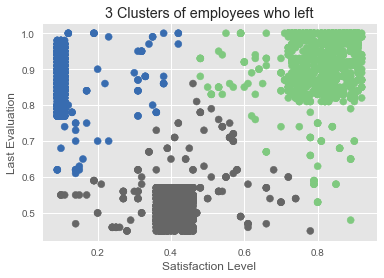

In [92]:
from sklearn.cluster import KMeans
left_emp =  data[['satisfaction_level', 'last_evaluation']][data.left == 1]
# Create groups using K-means clustering.
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(left_emp)
left_emp['label'] = kmeans.labels_
# Draw scatter plot
plt.scatter(left_emp['satisfaction_level'], left_emp['last_evaluation'], c=left_emp['label'],cmap='Accent')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.title('3 Clusters of employees who left')
plt.show()

Here, Employee who left the company can be grouped into 3 type of employees:

- High Satisfaction and High Evaluation(Shaded by green color in the graph), you can also call them Winners.
- Low Satisfaction and High Evaluation(Shaded by blue color(Shaded by green color in the graph), you can also call them Frustrated.
- Moderate Satisfaction and moderate Evaluation (Shaded by grey color in the graph), you can also call them 'Bad match'.

### Building a Prediction Model
---

In [93]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
data['salary']=le.fit_transform(data['salary'])
data['Departments ']=le.fit_transform(data['Departments '])

#Spliting data into Feature and
X=data[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'Departments ', 'salary']]
y=data['left']

In [94]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test
from sklearn.ensemble import GradientBoostingClassifier

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()

#Train the model using the training sets
gb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gb.predict(X_test)

from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9715555555555555
Precision: 0.958252427184466
Recall: 0.9207089552238806


- In the prediction case, when the Gradient Boosting model predicted an employee is going to leave, that employee actually left 95% of the time.

- If there is an employee who left present in the test set, the Gradient Boosting model can identify it 92% of the time.

